# **Dicoding - Belajar Pengembangan Machine Learning**
# Submission 2 - Time Series

### Daily Climate Time-Series Dataset<br>
https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

import os
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rakaputrawidyasf","key":"3d5ae91c469976eaffb6589099ee21a1"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


### Download Dataset


In [5]:
!kaggle datasets download sumanthvrao/daily-climate-time-series-data

  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 18.7MB/s]


In [6]:
zip_data = "daily-climate-time-series-data.zip"
zip_ref = zipfile.ZipFile(zip_data, "r")
zip_ref.extractall()
zip_ref.close()

### Read & Process CSV Data

In [7]:
df = pd.read_csv("DailyDelhiClimateTrain.csv", engine="python")
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [8]:
list(df.columns)

['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']

In [9]:
df.date = pd.to_datetime(df.date)

Select "wind_speed"

In [10]:
df_new = df.drop(["meantemp", "humidity", "meanpressure"], axis=1)
df_new

,date,wind_speed
0,2013-01-01,0.000000
1,2013-01-02,2.980000
2,2013-01-03,4.633333
3,2013-01-04,1.233333
4,2013-01-05,3.700000
...,...,...
1457,2016-12-28,3.547826
1458,2016-12-29,6.000000
1459,2016-12-30,6.266667
1460,2016-12-31,7.325000


Display

Text(0.5, 1.0, 'Daily Climate (Wind Speed)')

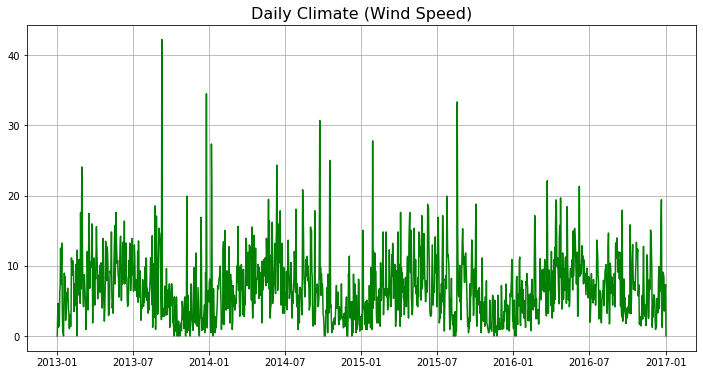

In [11]:
date = df_new["date"].values
wind_speed = df_new["wind_speed"].values

plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(date, wind_speed, color="g")
plt.title("Daily Climate (Wind Speed)", fontsize=16)

### Training & Validation

In [12]:
X_train, X_test, y_train, y_test = train_test_split(wind_speed, date,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=False)

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=2000)
test_set = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=2000)

In [15]:
model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 400)
])

In [16]:
optimizer = keras.optimizers.SGD(learning_rate=1.000e-04, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [17]:
X_min = df_new["wind_speed"].min()
X_min

0.0

In [18]:
X_max = df_new["wind_speed"].max()
X_max

42.22

In [19]:
X_avg = (X_max - X_min) * (10 / 100)
X_avg

4.222

In [20]:
class CallBack(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("mae") < X_avg):
      print("MAE of the model < 10% of data scale. Stop training...")
      self.model.stop_training = True

callbacks = CallBack()

In [21]:
history = model.fit(train_set,
                    epochs=50,
                    validation_data=test_set,
                    callbacks=[callbacks])

Epoch 1/50
12/12 [==============================] - 7s 211ms/step - loss: 22.5969 - mae: 23.0913 - val_loss: 9.7161 - val_mae: 10.2138
Epoch 2/50
12/12 [==============================] - 2s 123ms/step - loss: 35.3039 - mae: 35.7993 - val_loss: 4.3148 - val_mae: 4.7968
Epoch 3/50
12/12 [==============================] - 2s 119ms/step - loss: 36.1623 - mae: 36.6581 - val_loss: 30.3600 - val_mae: 30.8600
Epoch 4/50
12/12 [==============================] - 2s 122ms/step - loss: 23.8693 - mae: 24.3691 - val_loss: 30.0771 - val_mae: 30.5771
Epoch 5/50
12/12 [==============================] - 2s 122ms/step - loss: 23.8545 - mae: 24.3544 - val_loss: 27.6779 - val_mae: 28.1779
Epoch 6/50
12/12 [==============================] - 2s 125ms/step - loss: 23.2041 - mae: 23.7039 - val_loss: 35.1969 - val_mae: 35.6969
Epoch 7/50
12/12 [==============================] - 2s 121ms/step - loss: 23.6154 - mae: 24.1127 - val_loss: 31.3163 - val_mae: 31.8163
Epoch 8/50
12/12 [==============================] -

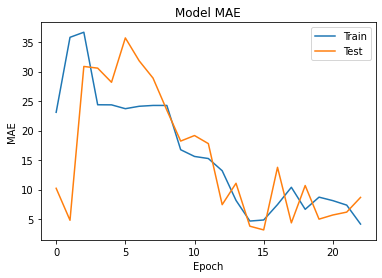

In [22]:
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.title("Model MAE")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper right")
plt.show()

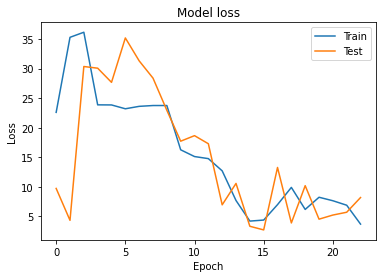

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper right")
plt.show()